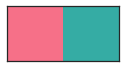

In [542]:
import os
import sys
import csv
import ast
import json
from datetime import datetime
from datetime import timedelta

import MyFunctions as MyFuncs

import numpy as np
import pandas as pd

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize']=(16, 10)

sns.set(style='white', palette='husl', font_scale=2)

sns.palplot(sns.color_palette("husl", 2))

#### Constant values to use in analysis

In [543]:
########################################################################
min_comfort = 18.5
max_comfort = 21.5
########################################################################
min_day = '2019-01-08 03:00:00'
max_day = '2019-01-15'
########################################################################
formatter = DateFormatter("%m-%d")   

#### Read in Baselineline file
create occupancy column, calculate comfort, create tidy datasets for Baseline

In [493]:

file_loc = '/Users/maggie/Documents/Github/DMU-Final-Project/resultFile_Baseline_v2.csv'
Baseline = pd.read_csv(file_loc, header=None)
Baseline.columns = ['Indoor', 'Ti_prime', 'Outdoor', 'Action', 'seconds', 'occupancy']
time = pd.date_range(start='12-31-2018',freq='1H', periods=len(Baseline))
Baseline['time'] = time

######################## write Time and Occ columns to use later ########################
seconds = Baseline['seconds']
Occ_Col = Baseline['occupancy']

######################## drop head and tail for baseline ########################
Baseline = Baseline.drop(Baseline.tail(25).index).drop(Baseline.head(24).index)

######################## Compute comfort and energy use for baseline ########################
Baseline['comfort'] = np.where((Baseline['Indoor']<max_comfort) & (Baseline['Indoor']>min_comfort) & (Baseline['occupancy'] == 0), 1, 0)
comfort_total = Baseline['comfort'].sum()
# energy_total = Baseline['action'].sum()
# print(f'Total Energy usage for baseline: {energy_total}')
print(f'Total comfort for baseline: {comfort_total}')

######################## Create melted data for Baseline ########################
Baseline_temps = pd.melt(Baseline, id_vars=['time'], value_vars=['Indoor', 'Outdoor'], var_name='Measurement', value_name='TempVal')
Baseline_actions = pd.melt(Baseline, id_vars=['time'], value_vars=['Action'], var_name='Action', value_name='EnergyVal')

################################################################################################

Total comfort for baseline: 372


#### Create bounds based on occupancy for highlighting plots

In [444]:
######################## Get highlight bounds for occupancy ########################
occ_start = Baseline[Baseline.occupancy == 1].time
occ_end = occ_start+timedelta(hours=1)
highlight_bounds = [(i,j) for i, j in zip(occ_start, occ_end)]

#### General function for reading in data files
- Attach occupancy columm
- Create time column
- Create "tidy" dfs for action and temperature readings
- Calculate energy use and comfort metric
- Returns full df and 2 tidy dfs

In [544]:
def read_data(file_loc, title, occ=Occ_Col, max_c=max_comfort, min_c=min_comfort):
    df = pd.read_csv(file_loc, header=None)
    df.columns = ['Indoor', 'Ti_prime', 'Outdoor', 'action']
    time = pd.date_range(start='12-31-2018',freq='1H', periods=len(df))
    df['time'] = time
    df['occupancy'] = occ
    df = df.drop(df.tail(25).index).drop(df.head(24).index)
    df.action = df.action.astype(float)
    
    df['comfort'] = np.where((df['Indoor']<max_c) & (df['Indoor']>min_c) & (df['occupancy'] == 0), 1, 0)
    comfort_total = df['comfort'].sum()
    energy_total = df['action'].sum()
    
    print(f'Total Comfort {title}: {comfort_total}')
    print(f'Total Energy usage {title}: {energy_total}')    
    
#     LongTemps = pd.melt(df, id_vars=['time'], value_vars=['Indoor', 'Outdoor'], var_name='Type', value_name='TempVal')
#     LongActions = pd.melt(df, id_vars=['time'], value_vars=['Action'], var_name='Action', value_name='EnergyVal')

    return df, (comfort_total, energy_total/1000)
#     return energy_total, df, LongTemps, LongActions

#### Read in all results file (iterations) and combine into one

In [547]:
############# Join all iterations together #########################
i_cols = ['time', 'Indoor', 'action', 'Iteration']
iterations = pd.DataFrame(columns = i_cols)
iteration_path = os.path.join('/Users/maggie/Documents/Github/DMU-Final-Project/NewResults')
results = sorted(MyFuncs.mylistdir(iteration_path, '.csv'))
# CE_curve = pd.DataFrame(columns=['Comfort', 'Energy'])
CE_curve_iters = []
for i_file in results:
    i = f'Iteration {i_file.split("-")[1].strip(".csv")}'
    out = read_data(os.path.join(iteration_path, i_file), i)
    df = out[0]
    CE_curve_iters.append(out[1])
    

    
    df['Iteration'] = i
    df = df[i_cols]
    iterations = iterations.append(df)
print(CE_curve_iters)

Total Comfort Iteration 1: 102
Total Energy usage Iteration 1: 726500.0
Total Comfort Iteration 2: 98
Total Energy usage Iteration 2: 723000.0
Total Comfort Iteration 3: 97
Total Energy usage Iteration 3: 723000.0
Total Comfort Iteration 4: 101
Total Energy usage Iteration 4: 723000.0
Total Comfort Iteration 5: 100
Total Energy usage Iteration 5: 723000.0
Total Comfort Iteration 6: 102
Total Energy usage Iteration 6: 720500.0
[(102, 726.5), (98, 723.0), (97, 723.0), (101, 723.0), (100, 723.0), (102, 720.5)]


[(102, 726.5), (98, 723.0), (97, 723.0), (101, 723.0), (100, 723.0), (102, 720.5)]
[(64, 519.0), (65, 536.0), (80, 622.5), (74, 621.0), (102, 726.5)]


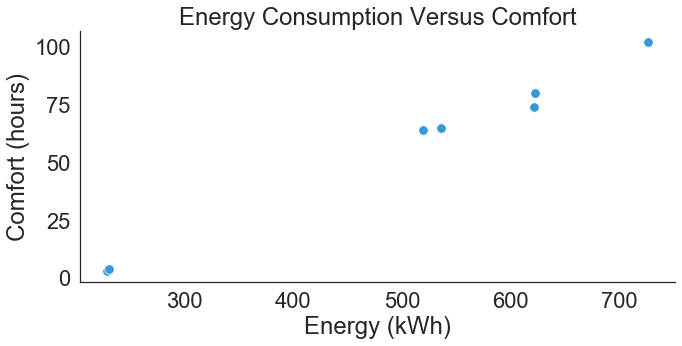

In [554]:
# comfort_energy = pd.DataFrame(columns)
print(CE_curve_iters)
print(CE_curve_policies[2:])


CE_df_iters = pd.DataFrame(CE_curve_iters, columns =['Comfort', 'Energy'], dtype = float)
CE_df_iters['Type'] = 'Iterated'

CE_df_policies = pd.DataFrame(CE_curve_policies, columns =['Comfort', 'Energy'], dtype = float)
CE_df_policies['Type'] = 'Policy Baselines'

# CE_df = CE_df_iters.append(CE_df_policies[2:])


colors = ["#3498db", "#e74c3c"]
with sns.color_palette(colors):
    g = sns.relplot(x='Energy', y='Comfort', kind='scatter', data=CE_df_policies, height=5, aspect=2, s = 90) # hue='Type'
g.set(xlabel='Energy (kWh)', ylabel='Comfort (hours)', title='Energy Consumption Versus Comfort')
g.savefig(f'/Users/maggie/Desktop/DMU_figures/energy_vs_comfort_new.png')

#### Plot all 10 iterations - indoor temperatures

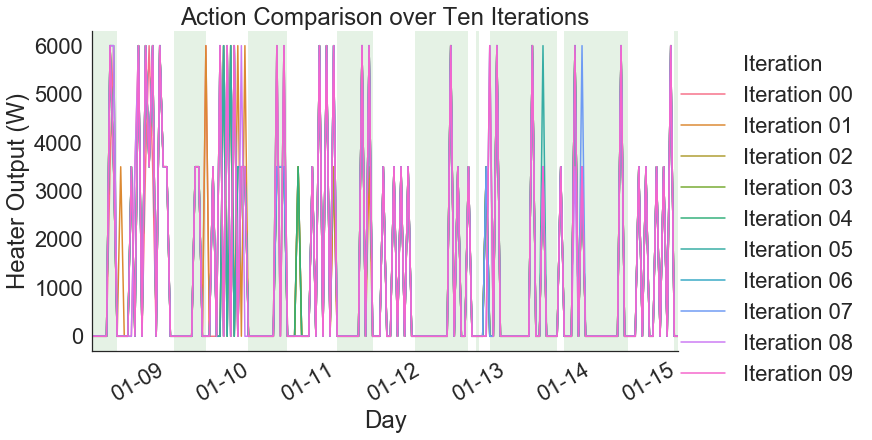

In [477]:

with sns.color_palette('hls'):
    g = sns.relplot(x='time', y='action', hue='Iteration', kind='line', data=iterations, height = 6, aspect=1.7)
g.set(xlabel='Day', ylabel='Heater Output (W)', title = 'Action Comparison over Ten Iterations', xlim=(min_day, max_day)) #ylim=(-5, 30)
for ax in g.axes.flat:
    plt.gcf().autofmt_xdate()
    ax.xaxis.set_major_formatter(formatter)

for x in highlight_bounds:
    plt.axvspan(x[0], x[1], facecolor='green', edgecolor='none', alpha=0.1)    
g.savefig(f'/Users/maggie/Desktop/DMU_figures/iter_compare_actions.pdf')

#### Plot all 10 iterations by actions

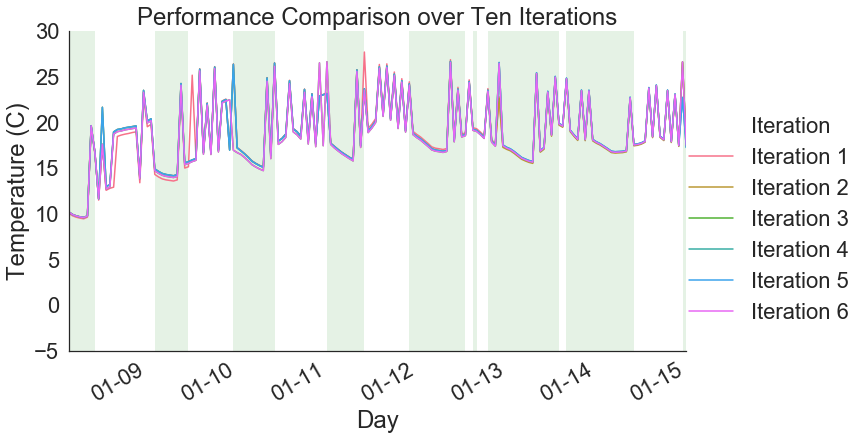

In [563]:
######################## Plotting All iterations ########################
sns.set(style='white', palette='husl', font_scale=2)

g = sns.relplot(x='time', y='Indoor', hue='Iteration', kind='line', data=iterations, height = 6, aspect=1.7)
g.set(xlabel='Day', ylabel='Temperature (C)', title = 'Performance Comparison over Ten Iterations', ylim=(-5, 30), xlim=(min_day, max_day))
for ax in g.axes.flat:
    plt.gcf().autofmt_xdate()
    ax.xaxis.set_major_formatter(formatter)

for x in highlight_bounds:
    plt.axvspan(x[0], x[1], facecolor='green', edgecolor='none', alpha=0.1)    
g.savefig(f'/Users/maggie/Desktop/DMU_figures/iter_compare_temps_new.png')

################################################################################################

#### Plot action and temperatures together on same plot

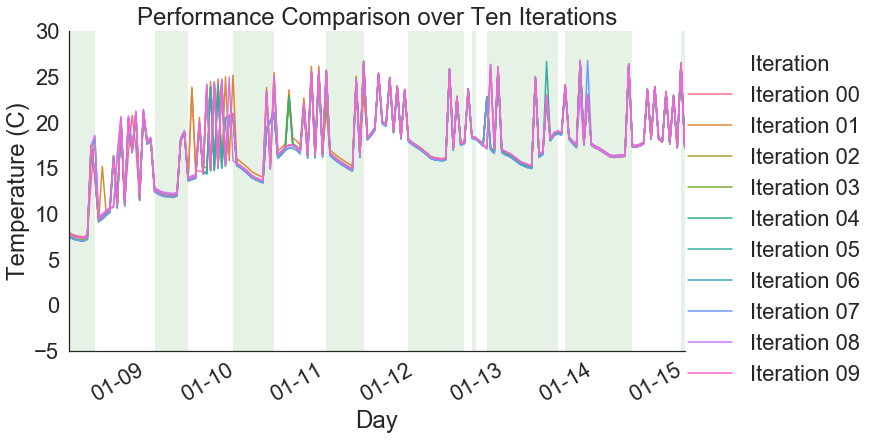

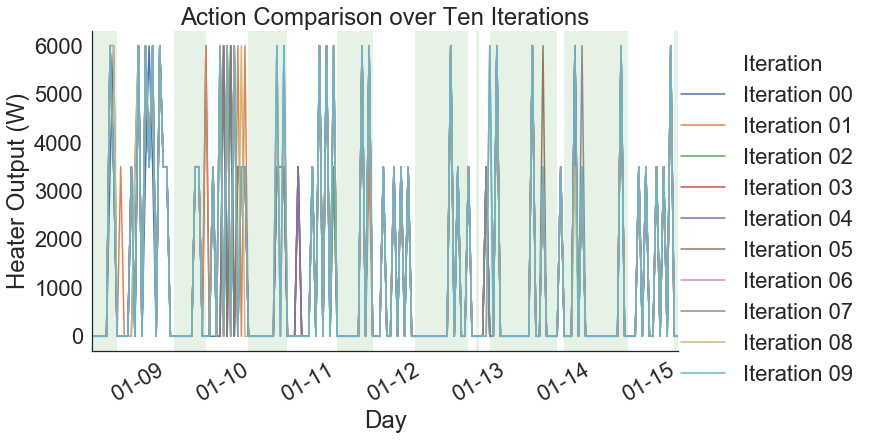

In [490]:
# fig, axs = plt.subplots(2)

axs[0] = sns.relplot(x='time', y='Indoor', hue='Iteration', kind='line', data=iterations, height = 6, aspect=1.7)
axs[0].set(xlabel='Day', ylabel='Temperature (C)', title = 'Performance Comparison over Ten Iterations', ylim=(-5, 30), xlim=(min_day, max_day))

for ax in axs[0].axes.flat:
    plt.gcf().autofmt_xdate()
    ax.xaxis.set_major_formatter(formatter)
    
for x in highlight_bounds:
    plt.axvspan(x[0], x[1], facecolor='green', edgecolor='none', alpha=0.1)    


# fig.suptitle('Vertically stacked subplots')
with sns.color_palette('deep'):
    axs[1] = sns.relplot(x='time', y='action', hue='Iteration', kind='line', data=iterations, height = 6, aspect=1.7)
    axs[1].set(xlabel='Day', ylabel='Heater Output (W)', title = 'Action Comparison over Ten Iterations', xlim=(min_day, max_day)) #ylim=(-5, 30)

for ax in axs[1].axes.flat:
    plt.gcf().autofmt_xdate()
    ax.xaxis.set_major_formatter(formatter)
    
for x in highlight_bounds:
    plt.axvspan(x[0], x[1], facecolor='green', edgecolor='none', alpha=0.1)    
# g.savefig(f'/Users/maggie/Desktop/DMU_figures/iter_compare_actions.pdf')

# axs.savefig(f'/Users/maggie/Desktop/DMU_figures/iter_compare_actions.pdf')



#### Read in results from all policy files and make plots

In [524]:
######################## Read in the policy outputs ########################
root_dir = os.path.join('/Users/maggie/Documents/Github/DMU-Final-Project/policy_results')
policy_files = sorted(MyFuncs.mylistdir(root_dir, '.csv'))
policy_dfs = {}
CE_curve_policies = []

for p_file in policy_files:
    R = p_file.split('policy ')[1].strip(' .csv')
    out = read_data(os.path.join(root_dir, p_file), R)
    policy_dfs[R] = out[0]
    CE_curve_policies.append(out[1])
    
print(CE_curve_policies)

    
######################## Combine relevant columns for plotting initial policy results given different reward functions ########################
r_cols = ['time', 'Indoor', 'comfort', 'action', 'Function']
rewards = pd.DataFrame(columns = r_cols)
for r in policy_dfs:
    small_df = policy_dfs[r]
    small_df['Function'] = r
    small_df = small_df[r_cols]
    rewards = rewards.append(small_df)

Total Comfort R1: 3
Total Energy usage R1: 229000.0
Total Comfort R2: 4
Total Energy usage R2: 230500.0
Total Comfort R3: 64
Total Energy usage R3: 519000.0
Total Comfort R4: 65
Total Energy usage R4: 536000.0
Total Comfort R5: 80
Total Energy usage R5: 622500.0
Total Comfort R6: 74
Total Energy usage R6: 621000.0
Total Comfort R7: 102
Total Energy usage R7: 726500.0
[(3, 229.0), (4, 230.5), (64, 519.0), (65, 536.0), (80, 622.5), (74, 621.0), (102, 726.5)]


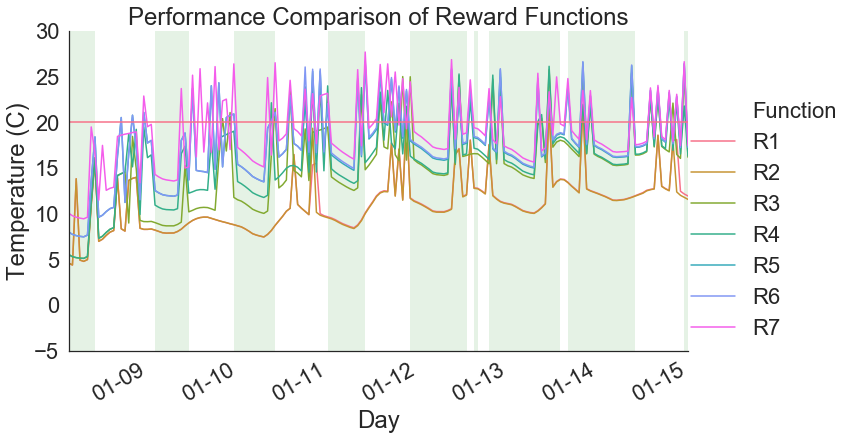

In [560]:



######################## Plotting All Policy baselines ########################

g = sns.relplot(x='time', y='Indoor', hue='Function', kind='line', data=rewards, height = 6, aspect=1.7)
g.set(xlabel='Day', ylabel='Temperature (C)', title = 'Performance Comparison of Reward Functions', ylim=(-5, 30), xlim=(min_day, max_day))#, legend=False)#, fontsize=10)


for ax in g.axes.flat:
    plt.gcf().autofmt_xdate()
    ax.xaxis.set_major_formatter(formatter)
g.axes[0][0].axhline(20, ls='-')
for x in highlight_bounds:
    plt.axvspan(x[0], x[1], facecolor='green', edgecolor='none', alpha=0.1)    
g.savefig(f'/Users/maggie/Desktop/DMU_figures/RewardCompare_occ.pdf')


# ax1, ax2 = g.axes[0]

# ax1.axhline(10, ls='--')
################################################################################################

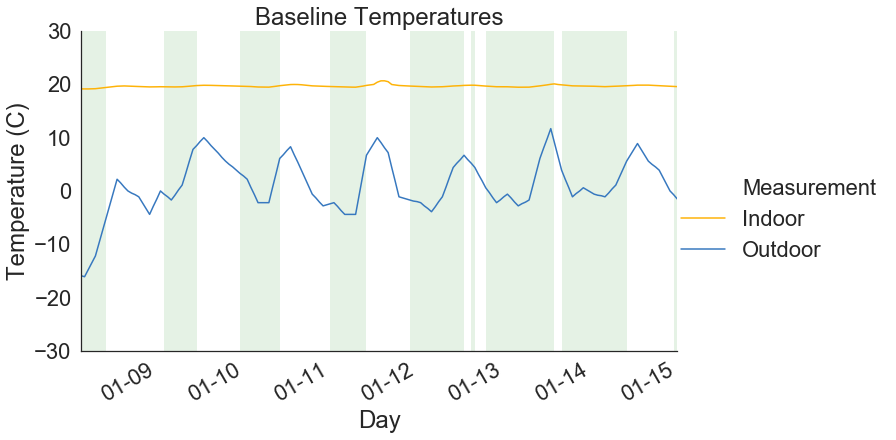

In [383]:
def plot_T(df, title, bounds):    
    g = sns.relplot(x='time', y='TempVal', hue='Measurement', kind='line', data=df, height = 6, aspect=1.7)
    for x in bounds:
        plt.axvspan(x[0], x[1], facecolor='green', edgecolor='none', alpha=0.1)    
    g.set(xlabel='Day', ylabel='Temperature (C)', title = 'Baseline Temperatures', ylim=(-30, 30), xlim=(min_day, max_day))#, legend=False)#, fontsize=10)
    for ax in g.axes.flat:
        plt.gcf().autofmt_xdate()
        ax.xaxis.set_major_formatter(formatter)
    g.savefig(f'/Users/maggie/Desktop/DMU_figures/{title}.pdf')



colors = ["amber", "windows blue"]
with sns.xkcd_palette(colors):
    plot_T(Baseline_temps, 'Temperature_Baseline', highlight_bounds)

